No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


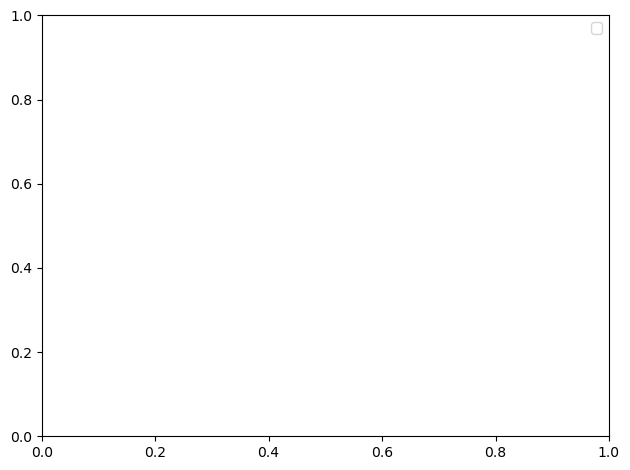

In [1]:
import os
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import LeaveOneOut

from library.utils import *
from library.model import *
from library.outlier import *
from library.active_learning import *

## Input: only modify here

- Data_folder: path to folder contains all experiment data, files must be csv, with row as experiment, each column contains concentration. NOTE: please name file with active learning round number, ex: plate_AL_1, plate_AL_2...
- Target: columns names which will not included in input X for modelling
- Name_list : column names of each repetition measurement
- Parameter file: path and file name must be csv, with each component as row, names in first column, then maximun concentration and different ratio in each column


- nb_rep: how many random train/test subset to evaluate model parameters, the bigger the better, but take longer to run
- Flatten: True if using all repetitions for fitting, False if using their mean 
- Seed: a random number for reproductivity of new random experiment generated, please change each round
- Nb_new_data_predict : number of random experiment generated, without repeat with exited experiments
- Nb_new_data : number of new experiments suggest for next round


- Theta: parameter to control ratio of exploitation/exploration, only concern if using ucb as acquisation function
- Save_name: path and file names for result files

In [2]:
data_folder = "data\\lea\\data"
target = ['yield_1','yield_2','yield_3','yield', 'yield_std']
name_list = ['yield_1','yield_2','yield_3']
parameter_file = "data\\lea\\params.csv"

nb_rep = 100
flatten = True
seed = 43
nb_new_data_predict = 10000
nb_new_data = 50

statergy = 'ucb'
theta = 20 # for ucb formular
save_name = 'data\lea\lea_new_experiment\\round2'

Read parameter file:
- check if component names are correct 
- verbose = False if you don't want to print out any information
- Poolsize is number of all possible combination/ experiments based on provided condition list
- Searching ratio is percentage of new data seen in active learning compare to poolsize

In [3]:
element_list, element_max, sampling_condition = import_parameter(parameter_file, nb_new_data_predict, verbose = True)

Number of metabolites : 8
Number of combinations - poolsize : 1679616
Searching ratio : 0.6 %
Possible concentrations: 


,Mg-glutamate,K-glutamate,Amino acid,Spermidine,3-PGA,NTPs,PEG-8000,DNA
0,0.00,0.0,0.0000,0.000,0.00,0.0000,0.00,1.0
1,1.53,40.8,0.3825,0.255,7.65,0.3825,0.51,2.8
2,2.97,79.2,0.7425,0.495,14.85,0.7425,0.99,4.6
3,4.50,120.0,1.1250,0.750,22.50,1.1250,1.50,6.4
4,6.03,160.8,1.5075,1.005,30.15,1.5075,2.01,8.2
5,9.00,240.0,2.2500,1.500,45.00,2.2500,3.00,10.0


Read all csv file in data folder, check if their column names and orders are the same, if not then skip file
 - Please check if all files you want appeared (using verbose = True)
 - if print out "All files have consistent column orders" => good to go

In [4]:
data, size_list = import_data(data_folder, verbose = True)
data = data.iloc[:,1:] # drop index read as first column, only for Lea
check_column_names(data,target,element_list)

Read  2  files: 
-  plate_AL_1_raw_yield_MG_full.csv
-  plate_AL_2_rearrange.csv


,Buffer,Mg-glutamate,K-glutamate,Amino acid,Spermidine,3-PGA,NTPs,PEG-8000,DNA,yield_1,yield_2,yield_3,yield,yield_std
0,Buffer 1,6.03,240.0,2.2500,1.005,0.00,1.1250,0.99,6.4,0.031316,0.027513,-0.068428,-0.003200,0.056522
1,Buffer 2,9.00,0.0,0.7425,0.000,0.00,0.7425,0.99,8.2,0.024279,-0.161239,0.024977,-0.037328,0.107311
2,Buffer 3,2.97,160.8,1.5075,1.005,7.65,1.1250,1.50,6.4,0.271092,-0.015076,-0.008478,0.082513,0.163348
3,Buffer 4,4.50,160.8,0.0000,0.255,14.85,0.3825,1.50,10.0,-0.002863,-0.092491,-0.079632,-0.058329,0.048463
4,Buffer 5,9.00,40.8,0.3825,0.255,30.15,0.0000,2.01,2.8,-0.126154,-0.361608,-0.196143,-0.227968,0.120910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Buffer 46,0.00,120.0,2.2500,1.005,30.15,2.2500,0.00,4.6,2.014597,0.201385,0.359826,0.858603,1.004250
149,Buffer 47,9.00,40.8,2.2500,0.495,0.00,2.2500,2.01,2.8,0.236204,0.005643,0.043201,0.095016,0.123706
150,Buffer 48,1.53,0.0,0.7425,0.000,7.65,2.2500,1.50,10.0,0.611654,0.128190,0.835624,0.525156,0.361562
151,Buffer 49,0.00,120.0,1.5075,1.500,7.65,2.2500,3.00,8.2,0.946596,0.968932,0.460347,0.791959,0.287401


All files have consistent column orders.
All column names matched!


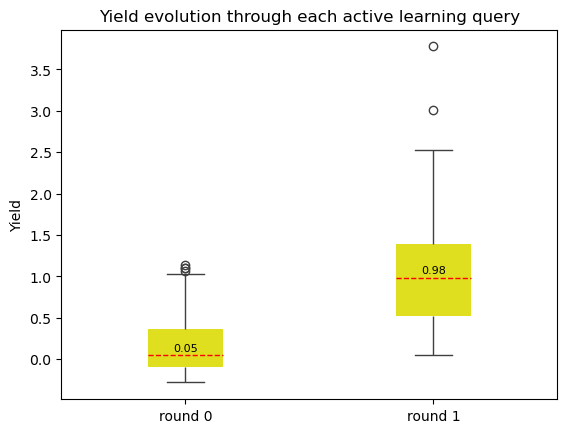

In [5]:
no_element = len(element_list)
y = np.array(data[name_list])
y_mean = np.mean(y, axis = 1)
X = data.iloc[:,0:no_element]
plot_each_round(y_mean,size_list)

## Modelling

- Normalized X by deviding with each columns maximum
- Using grid-search and 5 folds cross validation to find best kernel for gaussian process, training on ALL data
- Measure the best parameter performance by evaluate on different testing subset

In [6]:
X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0, flatten = flatten)

scaler = MaxAbsScaler()
X_train_norm = scaler.fit_transform(X_train)

model = BayersianModels(n_folds= 10, model_type = 'gp')
#model = BayersianModels(n_folds= 5, model_type = 'gp')

model.train(X_train_norm, y_train)
y_pred_train, std_pred_train = model.predict(X_train_norm) 

Best hyperparameter found: {'kernel': Matern(length_scale=1, nu=1.5) + 1**2 + WhiteKernel(noise_level=1)}


Text(0.5, 1.0, 'Histogram of R2 for different testing subset, mean = 0.62')

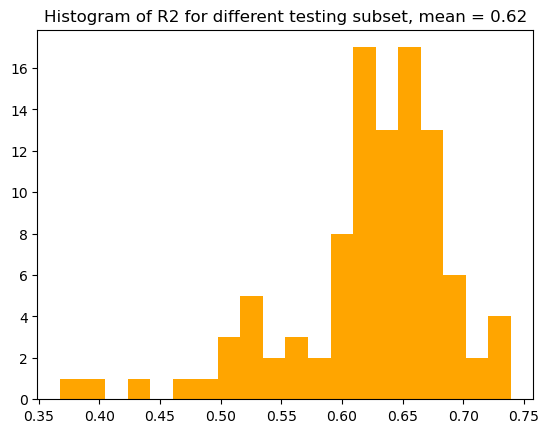

In [7]:
best_param = {'kernel': [model.best_params['kernel']]}
res = []
for i in range(nb_rep):
    X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0.2, flatten = flatten)

    scaler = MaxAbsScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    eva_model = BayersianModels(model_type ='gp', params= best_param)
    eva_model.train(X_train_norm, y_train, verbose = False)
    y_pred, std_pred = eva_model.predict(X_test_norm)
    res.append(r2_score(y_test, y_pred))

plt.hist(res, bins = 20, color='orange')
plt.title(f'Histogram of R2 for different testing subset, mean = {np.mean(res):.2f}', size = 12)

## Active Learning

- From condition lists, generated randomly "nb_new_data_predict" new experiments
- Used trained model above to predict yields from these new experiments
- Using 3 search stategy/acquisation functions (ucb, pi, ei) to calculate usefulness of each of these experiment (or increase model performance or has high yield)
- Select top "nb_new_data" new experiments which are the most benefit to test in lab
- Also print out highest yield predicted through model in selected points

In [8]:
X_new= sampling_without_repeat(sampling_condition, nb_sample = nb_new_data_predict, exited_data=X_train, seed = seed)
X_new_norm = scaler.transform(X_new)
y_pred, std_pred = model.predict(X_new_norm)

ucb = y_pred + theta*std_pred
pi = probability_of_improvement(y_pred, std_pred, max(y_train))
ei = expected_improvement(y_pred, std_pred, max(y_train))

print("For UCB:")
ucb_top, y_ucb, ratio_ucb = find_top_element(X_new, y_pred,ucb, nb_new_data, return_ratio= True)

print("For PI:")
pi_top, y_pi, ratio_pi = find_top_element(X_new, y_pred, pi, nb_new_data, return_ratio= True)

print("For EI:")
ei_top, y_ei, ratio_ei = find_top_element(X_new, y_pred, ei, nb_new_data, return_ratio= True)

For UCB:
Maximum yield prediction = 2.6999059061899526
For PI:
Maximum yield prediction = 2.6999059061899526
For EI:
Maximum yield prediction = 2.6999059061899526


### Explain graphs
- Plot histogram of yield/std: compare between all new experiments and already done experiments. Use to find if there's possible points to increase yield or calculated suitable theta to balance explore/exploit when using ucb
- Plot scatter compare yield and std of selected points with not selected points
- Plot eculide distance from each point to the first/most benefit point, this make sure new selected points arn't clusted (distance too close to first point) and benefit enough (has acquisation value significantly diffent from unslected points)

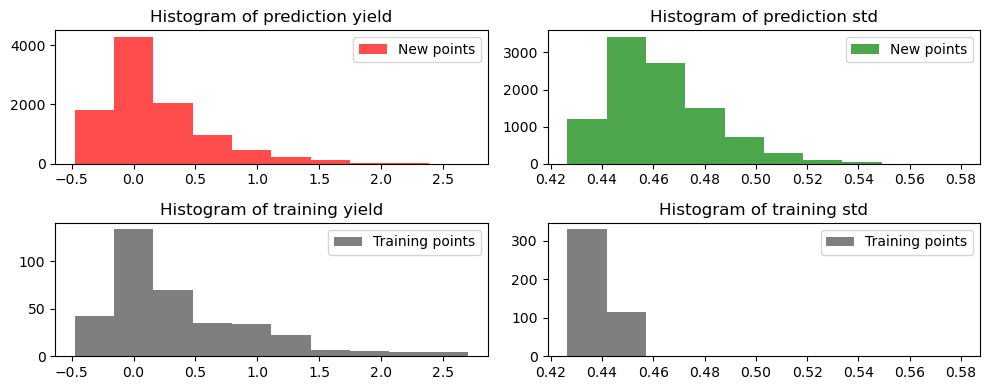

In [9]:
plot_hist_yield_std(y_pred, y_train, std_pred, std_pred_train)

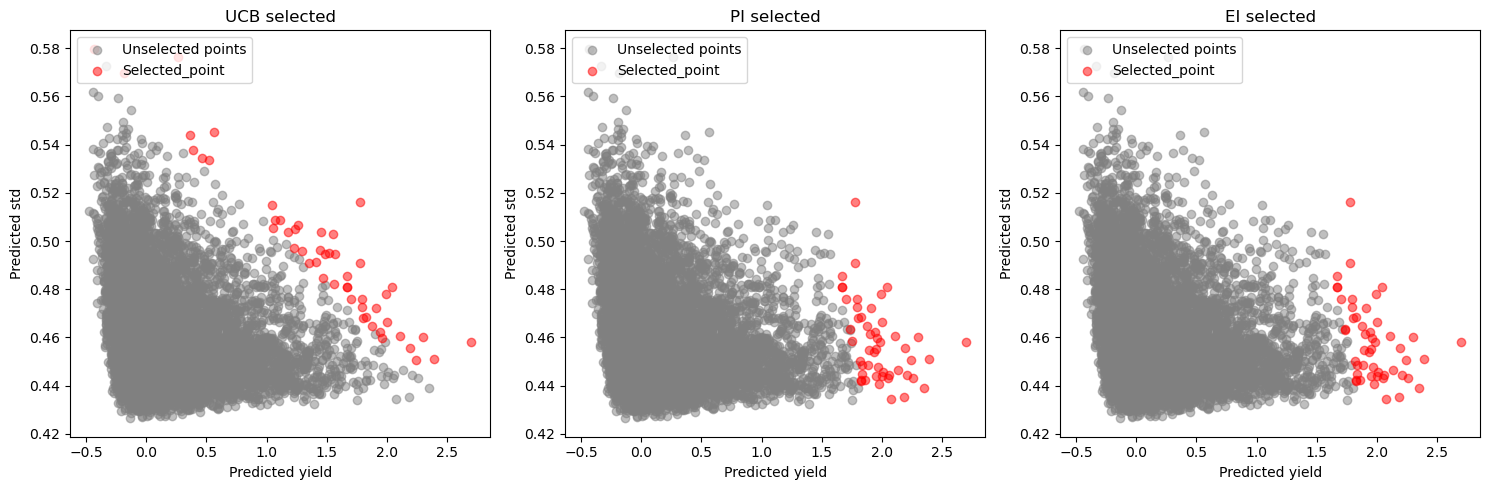

In [10]:
# Set up the figure with three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

plot_selected_point(axes[0], y_pred, std_pred, y_ucb, 'UCB selected')
plot_selected_point(axes[1], y_pred, std_pred, y_pi, 'PI selected')
plot_selected_point(axes[2], y_pred, std_pred, y_ei, 'EI selected')
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

#plot_hist_selected_yield(y_pred, y_ucb, title = 'UCB selected new data prediction yield')

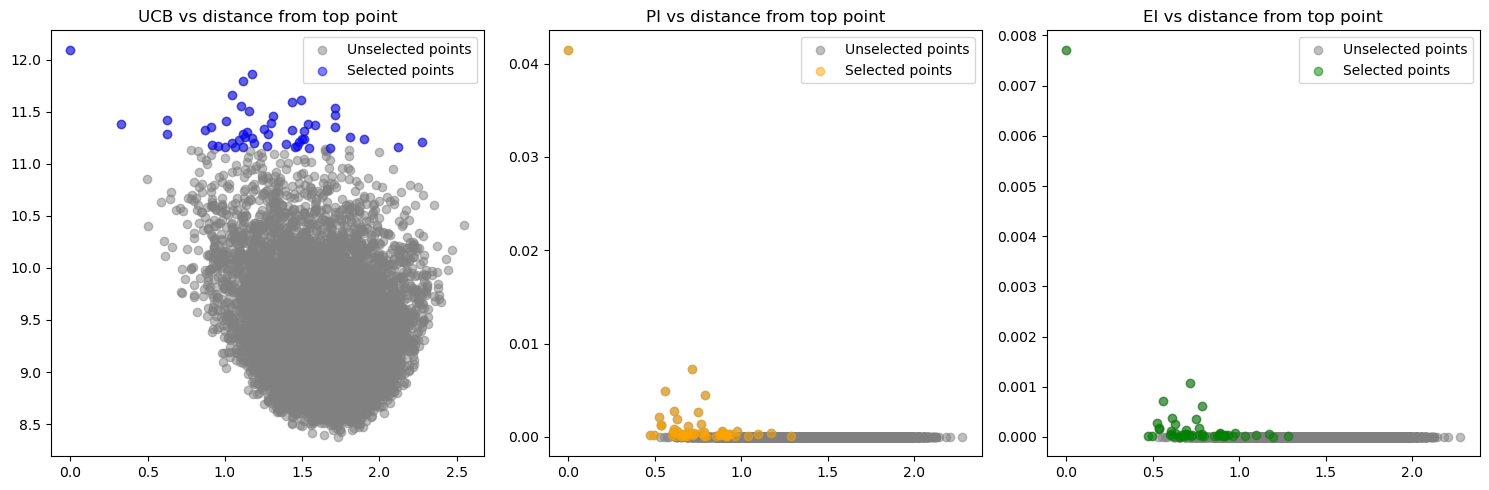

In [11]:
ucb_top_norm = scaler.transform(ucb_top)
pi_top_norm = scaler.transform(pi_top)
ei_top_norm = scaler.transform(ei_top)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_distance(axes[0], X_new_norm,ucb_top_norm, ucb, ratio_ucb, 'blue', 'UCB vs distance from top point')
plot_distance(axes[1], X_new_norm,pi_top_norm, pi, ratio_pi, 'orange', 'PI vs distance from top point')
plot_distance(axes[2], X_new_norm,ei_top_norm, ei, ratio_ei, 'green', 'EI vs distance from top point')

plt.tight_layout()
plt.show()

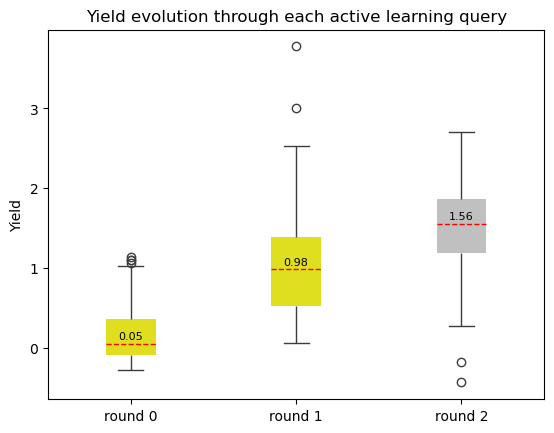

In [12]:
acq = {'ucb': y_ucb, 'pi': y_pi, 'ei': y_ei}
size_list.append(nb_new_data)
y_mean = np.append(y_mean, acq[statergy])
plot_each_round(y_mean,size_list, predict = True)

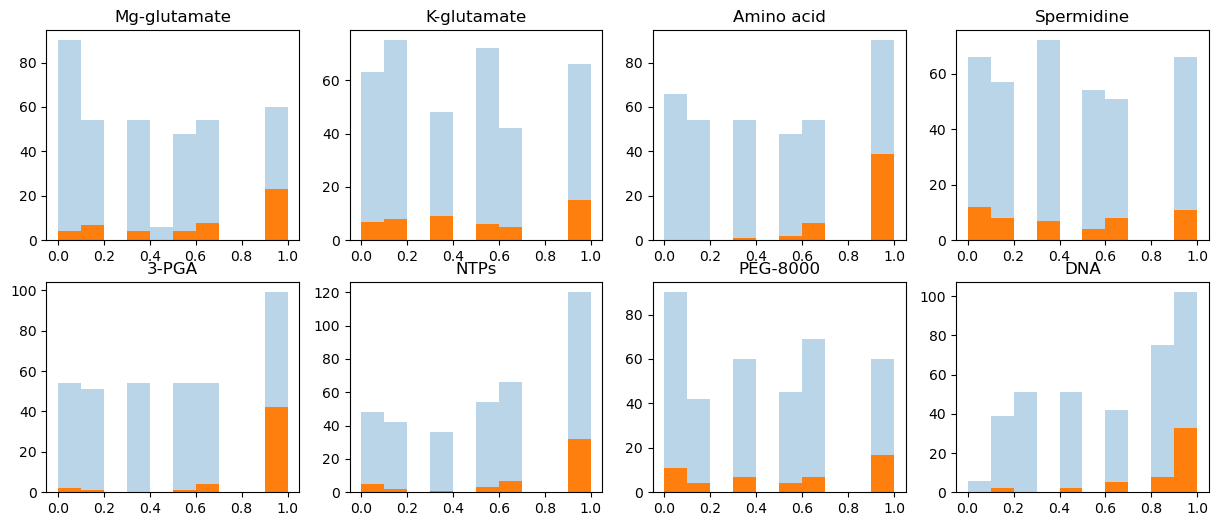

In [13]:
acq = {'ucb': ucb_top_norm, 'pi': pi_top_norm, 'ei': ei_top_norm}
plot_train_test(X_train_norm, acq[statergy], element_list)

## Model interprétation

- Plot heatmap of all generated experiments with its yield from low to high, color represent substance concentrations, use to look for each factor-X influence on yield-y
- Similar plot but zoom on top selected points

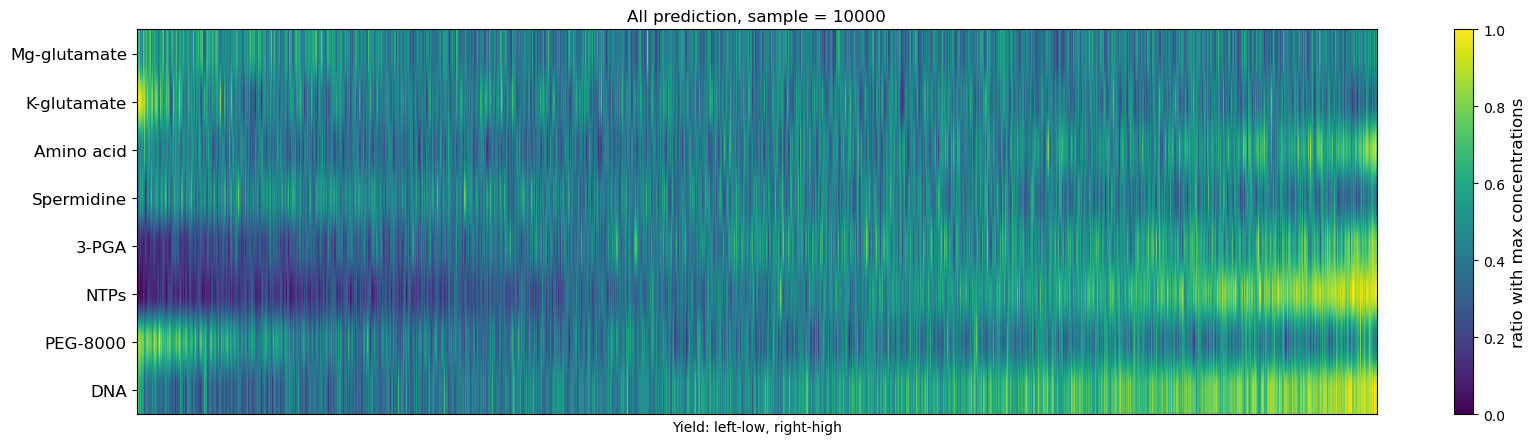

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
plot_heatmap(axes, X_new_norm, y_pred, element_list, 'All prediction')
plt.xlabel("Yield: left-low, right-high")
plt.show()

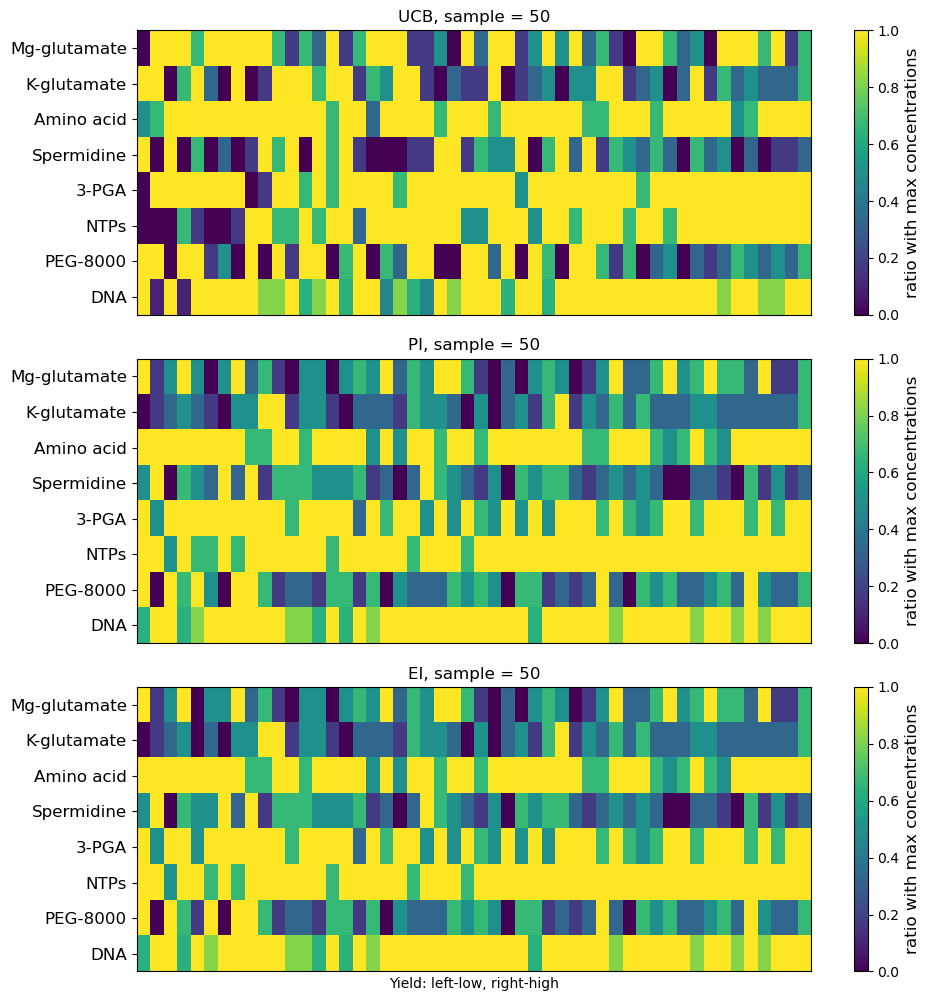

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
plot_heatmap(axes[0], ucb_top_norm, y_ucb, element_list, 'UCB')
plot_heatmap(axes[1], pi_top_norm, y_pi, element_list, 'PI')
plot_heatmap(axes[2], ei_top_norm, y_ei, element_list, 'EI')
plt.tight_layout()
plt.xlabel("Yield: left-low, right-high")
plt.show()

## Saving result

In [16]:
X_pi = pd.DataFrame(pi_top, columns=element_list)
name = save_name + '_pi.csv'
X_pi.to_csv(name, index=False)

X_ei = pd.DataFrame(ei_top, columns=element_list)
name = save_name + '_ei.csv'
X_ei.to_csv(name, index=False)

X_ucb = pd.DataFrame(ucb_top, columns=element_list)
name = save_name + '_ucb.csv'
X_ucb.to_csv(name, index=False)

In [17]:
data_new = pd.DataFrame(X_new, columns=element_list)
data_new.loc[:,'predict_yield'] = y_pred
data_new.loc[:,'pi'] = pi
data_new.loc[:,'ei'] = ei
data_new.loc[:,'ucb'] = ucb
data_new = pd.merge(X_ucb, data_new, on=element_list, how='left')
name = save_name + '_combine.csv'
data_new.to_csv(name, index=False)